# 1. Install and Import Dependencies

In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image
from copy import deepcopy

/home/cc/miniconda3/envs/central/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Load Model

In [2]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5n')

Using cache found in /home/cc/.cache/torch/hub/ultralytics_yolov5_master
requirements: matplotlib>=3.2.2 not found and is required by YOLOv5, attempting auto-update...
requirements: 'pip install matplotlib>=3.2.2' skipped (offline)
requirements: psutil not found and is required by YOLOv5, attempting auto-update...
requirements: 'pip install psutil' skipped (offline)
YOLOv5 🚀 2022-7-31 Python-3.8.13 torch-1.11.0+cu102 CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
model

# 3. Make Detections with Images

In [4]:
os.system('sudo umount -l ~/my_mounting_point')
os.system('cc-cloudfuse mount ~/my_mounting_point')
 
data_folder_path = '/home/cc/my_mounting_point/datasets'
dataset_folder_path = os.path.join(
    data_folder_path, 'ILSVRC/Data/DET/test'
)
classes_file_path = os.path.join(
    data_folder_path, 'imagenet_classes.txt'
)
 
image_names = os.listdir(dataset_folder_path)
image_names.sort()
with open(classes_file_path) as f:
    classes = [line.strip() for line in f.readlines()]

def image_loader(folder_path, image_name):
    image = Image.open(
        os.path.join(folder_path, image_name))
    # if there was a need to filter out only color images
    # if image.mode == 'RGB':
    #     pass
    return image
num_loaded_images = 4
images = {
    image_name: image_loader(
        dataset_folder_path, image_name) for image_name in image_names[
            :num_loaded_images]}

from torchvision import transforms
 
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)])
 
batch = torch.stack(list(map(lambda a: transform(a), list(images.values()))))



In [5]:
image_comp = 1

In [6]:
tensor_output = model(torch.unsqueeze(batch[image_comp], dim=0))

AttributeError: 'str' object has no attribute 'shape'

In [90]:
tensor_output.shape

torch.Size([1, 3087, 85])

In [84]:
image_output = model(list(images.values())[image_comp])

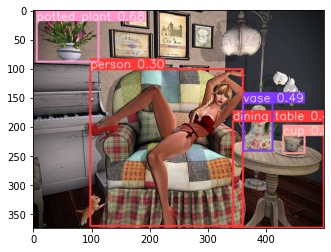

In [88]:
%matplotlib inline
plt.imshow(np.squeeze(image_output.render()))
plt.show()

In [93]:
image_output

In [73]:
tensor_output.shape

torch.Size([1, 3, 28, 28, 85])

# Add ONNX

In [ ]:
dummy_input = torch.randn(1, 3, 640, 640)
torch.onnx.export(
    model,
    dummy_input,
    f='model.onnx',
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'images': {
            0: 'batch',
            2: 'height',
            3: 'width'},  # shape(1,3,640,640)
        'output': {
            0: 'batch',
            1: 'anchors'}  # shape(1,25200,85)
    })

In [74]:
# use onnx model
import onnx
import onnxruntime
 
onnx_model = onnx.load('./model.onnx')
onnx.checker.check_model(onnx_model)
 
ort_session = onnxruntime.InferenceSession(
    os.path.join('./', "model.onnx"),
    providers=['CPUExecutionProvider'])
onnx_output = ort_session.run(None, {'input': batch.numpy()})
# onnx_output = torch.nn.functional.softmax(torch.tensor(onnx_output), dim=1)[0] * 100
# onnx_output = onnx_output.detach().numpy()
# onnx_output = onnx_output.argmax(axis=1)
# onnx_class = np.array(classes)[onnx_output]
# onnx_class

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input for the following indices
 index: 0 Got: 4 Expected: 1
 index: 2 Got: 224 Expected: 640
 index: 3 Got: 224 Expected: 640
 Please fix either the inputs or the model.

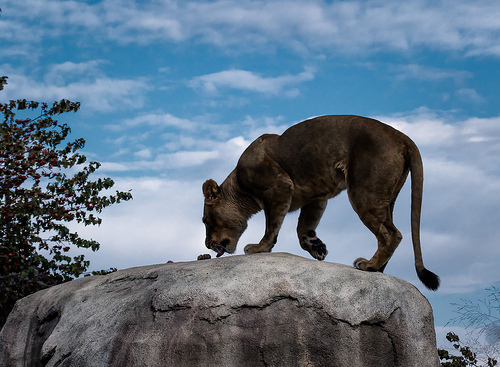

In [78]:
torch.unsqueeze(batch[image_comp], dim=0).shape

torch.Size([1, 3, 224, 224])